In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/movement-speeds.csv")
df.head()

,Unnamed: 0,day,hour,osm_way_id,speed_mph_mean,speed_mph_stddev,Latitude,Longitude
0,0,4,11,515486318,10.127,8.503,37.779522,-122.406901
1,1,1,12,515486318,11.217,9.453,37.779522,-122.406901
2,2,2,23,515486318,12.924,11.087,37.779522,-122.406901
3,3,1,0,515486318,13.827,9.969,37.779522,-122.406901
4,4,5,1,515486318,14.770,12.378,37.779522,-122.406901


In [3]:
df["time"]= (df["day"]-1) *24 + df["hour"]
df = df.sort_values(by = "time")
df.head()

,Unnamed: 0,day,hour,osm_way_id,speed_mph_mean,speed_mph_stddev,Latitude,Longitude,time
116977,116977,1,0,598020854,17.064,9.101,37.798169,-122.404337,0
121508,121508,1,0,620535183,30.618,5.563,37.893175,-122.530579,0
28117,28117,1,0,184255666,8.885,9.945,37.711521,-122.455590,0
121273,121273,1,0,513702094,59.773,6.543,37.732805,-122.404772,0
121178,121178,1,0,394558807,10.600,6.313,37.773167,-122.407792,0


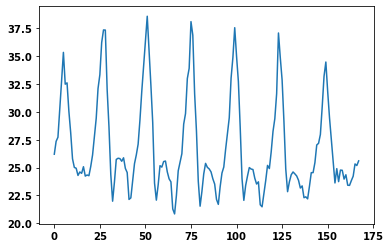

In [4]:
time = df.groupby(by = ["time"]).agg("mean").reset_index()
plt.plot(time["time"], time["speed_mph_mean"])

In [5]:
X = df[["time"]]
Y = df[["speed_mph_mean"]]

In [6]:
from numpy.linalg import inv

In [7]:
theta = inv(X.T @ X)@ X.T @Y
theta

,speed_mph_mean
0,0.216202


In [8]:
df["Yhat"] = X @ theta.to_numpy()

In [9]:
df

,Unnamed: 0,day,hour,osm_way_id,speed_mph_mean,speed_mph_stddev,Latitude,Longitude,time,Yhat
116977,116977,1,0,598020854,17.064,9.101,37.798169,-122.404337,0,0.000000
121508,121508,1,0,620535183,30.618,5.563,37.893175,-122.530579,0,0.000000
28117,28117,1,0,184255666,8.885,9.945,37.711521,-122.455590,0,0.000000
121273,121273,1,0,513702094,59.773,6.543,37.732805,-122.404772,0,0.000000
121178,121178,1,0,394558807,10.600,6.313,37.773167,-122.407792,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
13070,13070,7,23,32929983,25.072,4.717,37.767946,-122.425559,167,36.105756
128232,128232,7,23,158602255,12.814,4.462,37.771837,-122.481757,167,36.105756
35056,35056,7,23,530592670,18.134,3.869,37.764794,-122.424052,167,36.105756
17504,17504,7,23,89802405,17.917,4.076,37.757981,-122.476769,167,36.105756


In [10]:
# Scatter Plot Y vs. Y^
def plot_y_vs_yhat(df, y, yhat):
    plt.figure()
    Y, Yhat = df[y], df[yhat]
    plt.scatter(Yhat, Y, label = "(yhat, y)")
    cmin = max(Yhat.min(), Y.min())
    cmax = min(Yhat.max(), Y.max())
    plt.plot([cmin, cmax], [cmin, cmax],
            color = "red",
            label="y=yhat")
    plt.legend()

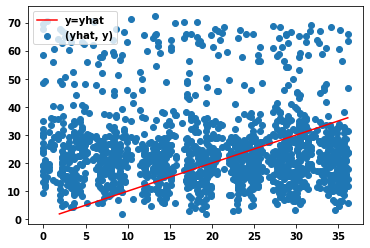

In [11]:
plot_y_vs_yhat(df.sample(frac=0.01),
              y="speed_mph_mean",
              yhat="Yhat")

In [12]:
#^ bad

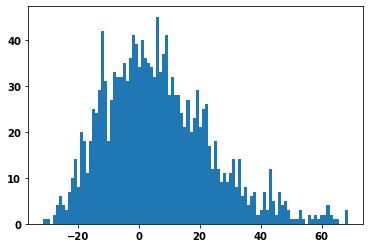

In [13]:
df["residuals"] = df["speed_mph_mean"]-df["Yhat"]
_= plt.hist(df.sample(frac=0.01)["residuals"], bins=100)

In [14]:
#~ large range

In [15]:
#compute L(e)
(df["residuals"] ** 2).mean()

345.75991698324754

In [16]:
# plot prediction
def plot_predictions(df, x, y, yhat):
    plt.figure()
    X, Y, Yhat = df[x], df[y],df[yhat]
    plt.plot(X, Y, label="groud truth")
    plt.plot(X, Yhat, label="prediction")
    plt.legend()

In [17]:
def plot_predictions_over_time(df, x, y, yhat):
    time=df.groupby(by="time").agg("mean").reset_index()
    plot_predictions(time, x, y, yhat)

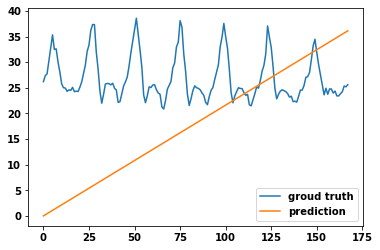

In [18]:
plot_predictions_over_time(df, x="time", y="speed_mph_mean", yhat="Yhat")

In [19]:
#^need to fix bias

In [20]:
def phi(X):
    return np.hstack([X, np.ones((X.shape[0],1))])

In [21]:
phi(X)

array([[  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       ...,
       [167.,   1.],
       [167.,   1.],
       [167.,   1.]])

In [22]:
theta2 = inv(phi(X).T @ phi(X))@ phi(X).T @Y
theta2

,speed_mph_mean
0,-0.010320
1,26.047099


In [23]:
df["Yhat2"] = phi(X)@theta2.to_numpy()
df.head()

,Unnamed: 0,day,hour,osm_way_id,speed_mph_mean,speed_mph_stddev,Latitude,Longitude,time,Yhat,residuals,Yhat2
116977,116977,1,0,598020854,17.064,9.101,37.798169,-122.404337,0,0.0,17.064,26.047099
121508,121508,1,0,620535183,30.618,5.563,37.893175,-122.530579,0,0.0,30.618,26.047099
28117,28117,1,0,184255666,8.885,9.945,37.711521,-122.455590,0,0.0,8.885,26.047099
121273,121273,1,0,513702094,59.773,6.543,37.732805,-122.404772,0,0.0,59.773,26.047099
121178,121178,1,0,394558807,10.600,6.313,37.773167,-122.407792,0,0.0,10.600,26.047099


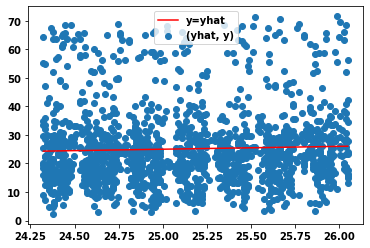

In [24]:
plot_y_vs_yhat(df.sample(frac=0.01),
              y="speed_mph_mean",
              yhat="Yhat2")

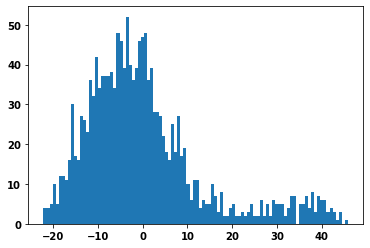

In [25]:
df["residuals2"]=df["speed_mph_mean"]-df["Yhat2"]
_= plt.hist(df.sample(frac=0.01)["residuals2"], bins=100)

In [26]:
#compute L(e)
(df["residuals2"] ** 2).mean()

186.94520321966797

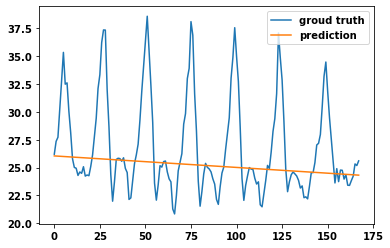

In [27]:
plot_predictions_over_time(df, x="time", y="speed_mph_mean", yhat="Yhat2")